<H1>Classification model evaluation</H1>

<h3>Import required libraries</h3>

In [2]:
import numpy as np # linear algebra
import os # reading data
import cv2 # reading images
from sklearn.preprocessing import MinMaxScaler
import pickle as cpickle # store data for fast processing

<h3>Load pickle files with our data.</h3>

In [4]:
training_data = cpickle.load(open('trainingDataUsingHog.pickle', 'rb'))
testing_data = cpickle.load(open('testingDataUsingHog.pickle', 'rb'))
validate_data = cpickle.load(open('validateDataUsingHog.pickle', 'rb'))

<h3>Show numbers of each class. </h3>

In [5]:
print('number of samples in training data: ', len(training_data))
print('number of samples in training data where category is Pneymonia: ', sum(map(lambda x : x[1] == 1, training_data.values())))
print('number of samples in training data where category is Normal: ', sum(map(lambda x : x[1] == 0, training_data.values())))
print('number of samples in testing data: ', len(testing_data))
print('number of samples in testing data where category is Pneymonia: ', sum(map(lambda x : x[1] == 1, testing_data.values())))
print('number of samples in testing data where category is Normal: ', sum(map(lambda x : x[1] == 0, testing_data.values())))
print('number of samples in validate data: ', len(validate_data))
print('number of samples in validate data where category is Pneymonia: ', sum(map(lambda x : x[1] == 1, validate_data.values())))
print('number of samples in validate data where category is Normal: ', sum(map(lambda x : x[1] == 0, validate_data.values())))

number of samples in training data:  5216
number of samples in training data where category is Pneymonia:  3875
number of samples in training data where category is Normal:  1341
number of samples in testing data:  624
number of samples in testing data where category is Pneymonia:  390
number of samples in testing data where category is Normal:  234
number of samples in validate data:  16
number of samples in validate data where category is Pneymonia:  8
number of samples in validate data where category is Normal:  8


<h3>Plot numbers of classes</h3>

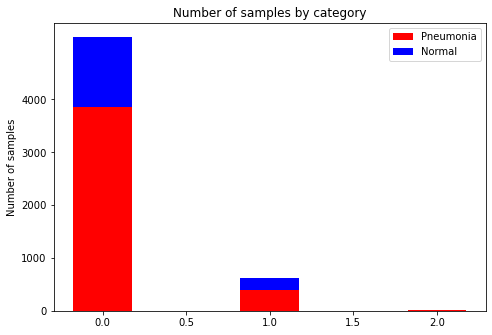

In [6]:
import numpy as np
import matplotlib.pyplot as plt
N = 3
pneumoniaDataSize = (3847, 390, 8)
normalDataSize = (1341, 234, 8)
ind = np.arange(N) # the x locations for the groups
width = 0.35
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, pneumoniaDataSize, width, color='r')
ax.bar(ind, normalDataSize, width,bottom=pneumoniaDataSize, color='b')
ax.set_ylabel('Number of samples')
ax.set_title('Number of samples by category')
ax.set_yticks(np.arange(0, 5000, 1000))
ax.legend(labels=['Pneumonia', 'Normal'])
plt.show()

<h3>Extract training, testing and validation set</h3>

In [7]:
x_Train = list(td[0] for td in training_data.values())
y_Train = list(td[1] for td in training_data.values())
x_Test = list(td[0] for td in testing_data.values())
y_Test = list(td[1] for td in testing_data.values())
x_Validate = list(td[0] for td in validate_data.values())
y_Validate = list(td[1] for td in validate_data.values())

<h3>Data preprocessing</h3>
<p>Standardize features by removing the mean and scaling to unit variance.</p>

In [8]:
from sklearn.preprocessing import StandardScaler
scalify = StandardScaler()
x_Train = scalify.fit_transform(x_Train)
x_Test = scalify.fit_transform(x_Test)

<h3>Show validation images results function.</h3>
<p>Plots the validation images with their class. In case of correct prediction the class name is green else the color is red.</p>

In [9]:
def ShowValidationImagesAndResults(model):
    global i
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10, 10))
    columns = 8
    rows = 2
    i = 1
    for file, value in validate_data.items():
        img = cv2.imread(file)
        ax = fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.axis('off')
        category = file.split('\\')[7].lower()
        predicted_value = model.predict(value[0].reshape(1, -1))
        color = 'green'
        if predicted_value != value[1]:
            color = 'red'
        ax.set_title(category, color=color)
        i = i + 1
    plt.show()

<h3>Show metrics function </h3>
<p>Function gets as parameters
<ol><li>labels, an array with labels</li>
<li>predictions, an array with models predictions</li></ol>
Function then shows the confusion matrix and the precision score of the model.</p>

<h4>Confusion matrix</h4>
<p> It is a performance measurement for machine learning classification problem where output can be two or more classes. It is a table with 4 different combinations of predicted and actual values. </p>
<img src="ImagesForNotebooks\ConfusionMatrix.png" alt="Confusion matrix">

<h4>Precision score</h4>
<p>The precision is the ratio TP / (TP + FP) where TP is the number of true positives and FP the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. In other words in our case, how good we predict pneumonia.</p>


In [10]:
def ShowMetrics(labels, predictions, model_name): 
    from sklearn.metrics import confusion_matrix
    import pandas as pd
    label_names = ['Normal', 'Pneumonia']
    cmx = confusion_matrix(labels, predictions)
    df = pd.DataFrame(cmx, columns=label_names, index=label_names)
    df.columns.name = 'prediction'
    df.index.name = 'label'
    print(df)
    from sklearn.metrics import precision_score
    pc = str(precision_score(labels, predictions))
    print('The precision score of the model is ' + pc)
    model_precision[model_name] = pc

<h3>Import required libraries for model selection</h3>
<p>In model selection we construct a dictionary with the parameters that we want to try in the model, runs all the possible combinations of them and return us the results of each model and the one with the best accuracy.</p>

In [33]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

<h3>Dictionary to store model and precision score</h3>

In [34]:
model_precision = {}

<h3>Run model selection for logistic regression</h3>
<p>Tried with different values for C, most specifically for 100, 10, 1.0, 0.1, 0.01.</p>

In [35]:
 from sklearn.linear_model import LogisticRegression

In [26]:
# define models and parameters
model = LogisticRegression()
c_values = [100, 10, 1.0, 0.1, 0.01]
iterations = [1000]
# define grid search
grid = dict(C=c_values, max_iter=iterations)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_Train, y_Train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.974054 using {'C': 0.01, 'max_iter': 1000}
0.971050 (0.007900) with: {'C': 100, 'max_iter': 1000}
0.971434 (0.007772) with: {'C': 10, 'max_iter': 1000}
0.971754 (0.007474) with: {'C': 1.0, 'max_iter': 1000}
0.972649 (0.008430) with: {'C': 0.1, 'max_iter': 1000}
0.974054 (0.007809) with: {'C': 0.01, 'max_iter': 1000}


<p> We now run logistic regression with the C that returned us the best accuracy score</p>

Accuracy of K-NN classifier on training set: 1.00
Accuracy of K-NN classifier on test set: 0.80
Accuracy of K-NN classifier on validate set: 0.50


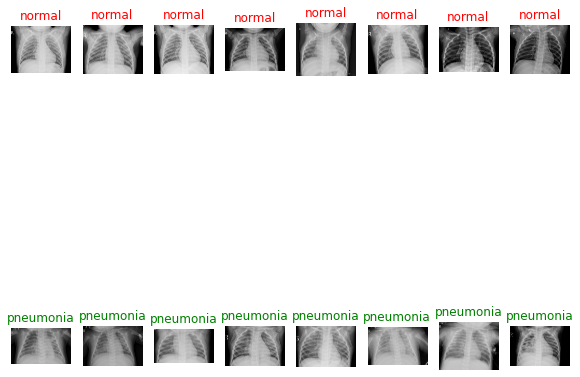

prediction  Normal  Pneumonia
label                        
Normal         120        114
Pneumonia       11        379
The precision score of the model is 0.768762677484787


In [36]:
lr = LogisticRegression(C= 0.01, max_iter = 1000)
lr.fit(x_Train, y_Train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
          .format(lr.score(x_Train, y_Train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
          .format(lr.score(x_Test, y_Test)))
print('Accuracy of K-NN classifier on validate set: {:.2f}'
          .format(lr.score(x_Validate, y_Validate)))

ShowValidationImagesAndResults(lr)
ShowMetrics(y_Test, lr.predict(x_Test), 'Logistic regression')

<h3>Run model selection for logistic regression</h3>
<p>Tried with different values for neighbors from 1 to 21.</p>

In [39]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# define models and parameters
model = KNeighborsClassifier()
n_neighbors = range(1, 21, 2)
# define grid search
grid = dict(n_neighbors=n_neighbors)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_Train, y_Train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

<p> We now run KNN with 11 neighbors as they had the best accuracy score</p>

Accuracy of K-NN classifier on training set: 1.00
Accuracy of K-NN classifier on test set: 0.82
Accuracy of K-NN classifier on validate set: 0.50


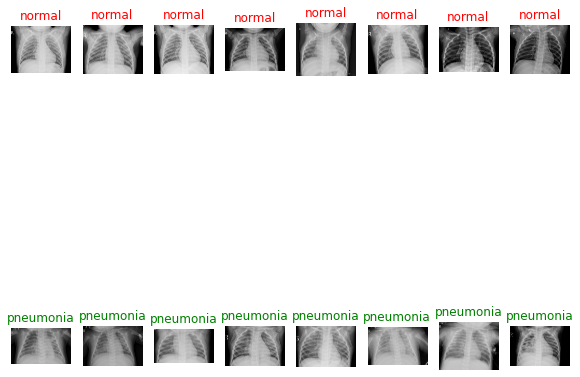

prediction  Normal  Pneumonia
label                        
Normal         158         76
Pneumonia       37        353
The precision score of the model is 0.8228438228438228


In [40]:
knn = KNeighborsClassifier(n_neighbors = 11, weights = 'distance', algorithm = 'kd_tree')
knn.fit(x_Train, y_Train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
          .format(knn.score(x_Train, y_Train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
          .format(knn.score(x_Test, y_Test)))
print('Accuracy of K-NN classifier on validate set: {:.2f}'
          .format(knn.score(x_Validate, y_Validate)))

ShowValidationImagesAndResults(knn)
ShowMetrics(y_Test, knn.predict(x_Test), 'KNN')

<h3>Run model selection for Discriminant analysis</h3>
<p>Tried with different values for solver from 'svd', 'lsqr', 'eigen'.</p>

In [41]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [42]:
model1 = LinearDiscriminantAnalysis()
solver_array = ['svd', 'lsqr', 'eigen']
grid = dict(solver = solver_array)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model1, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_Train, y_Train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.918837 using {'solver': 'svd'}
0.918837 (0.009435) with: {'solver': 'svd'}
0.918837 (0.009435) with: {'solver': 'lsqr'}
0.918837 (0.009435) with: {'solver': 'eigen'}


<p> We now run KNN with 11 neighbors as they had the best accuracy score</p>

Accuracy of LDA classifier on training set: 1.00
Accuracy of LDA classifier on test set: 0.79
Accuracy of LDA classifier on validate set: 0.50


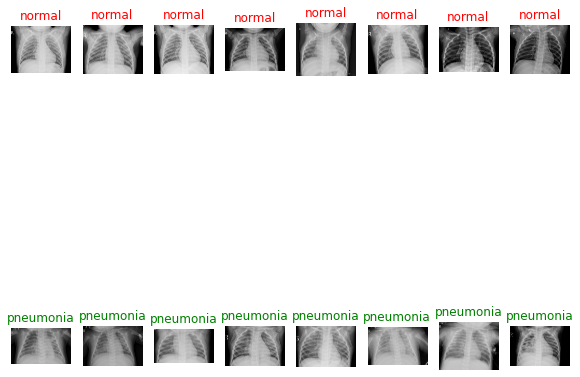

prediction  Normal  Pneumonia
label                        
Normal         119        115
Pneumonia       13        377
The precision score of the model is 0.766260162601626


In [43]:
lda = LinearDiscriminantAnalysis(solver = 'lsqr', shrinkage = 'auto')
lda.fit(x_Train, y_Train)
print('Accuracy of LDA classifier on training set: {:.2f}'
          .format(lda.score(x_Train, y_Train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
          .format(lda.score(x_Test, y_Test)))
print('Accuracy of LDA classifier on validate set: {:.2f}'
          .format(lda.score(x_Validate, y_Validate)))

ShowValidationImagesAndResults(lda)
ShowMetrics(y_Test, lda.predict(x_Test), 'Discriminant analysis')

<h3>Run Gaussian naive bayes</h3>
<p>There are no much we can tune in this model.</p>

Accuracy of GNB classifier on training set: 0.89
Accuracy of GNB classifier on test set: 0.76
Accuracy of GNB classifier on validate set: 0.50


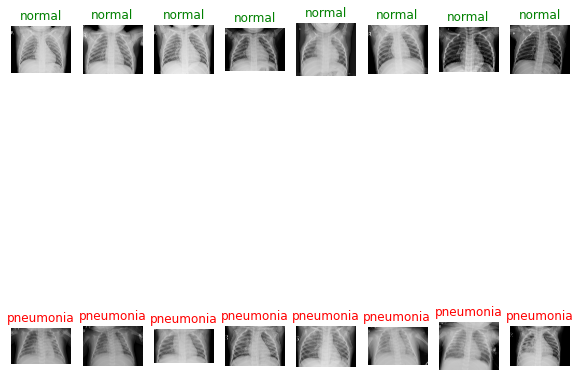

prediction  Normal  Pneumonia
label                        
Normal         140         94
Pneumonia       56        334
The precision score of the model is 0.780373831775701


In [44]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_Train, y_Train)
print('Accuracy of GNB classifier on training set: {:.2f}'
          .format(gnb.score(x_Train, y_Train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
          .format(gnb.score(x_Test, y_Test)))
print('Accuracy of GNB classifier on validate set: {:.2f}'
          .format(gnb.score(x_Validate, y_Validate)))
ShowValidationImagesAndResults(gnb)
ShowMetrics(y_Test, gnb.predict(x_Test), 'Gaussian naive bayes')

<h3>Run model selection for SVM</h3>
<p>Tried with different values for C, most specifically for 100, 10, 1.0, 0.1, 0.01 and for different kernels ('linear', 'poly', 'rbf', 'sigmoid', 'precomputed').</p>

In [45]:
from sklearn.svm import SVC

In [ ]:
model = SVC()
c_values = [100, 10, 1.0, 0.1, 0.01]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
grid = dict(C = c_values, kernel = kernel_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_Train, y_Train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

<p> We now run SVM with C = 100 and linear kernel.</p>

Accuracy of SVM classifier on training set: 1.00
Accuracy of SVM classifier on test set: 0.80
Accuracy of SVM classifier on validate set: 0.50


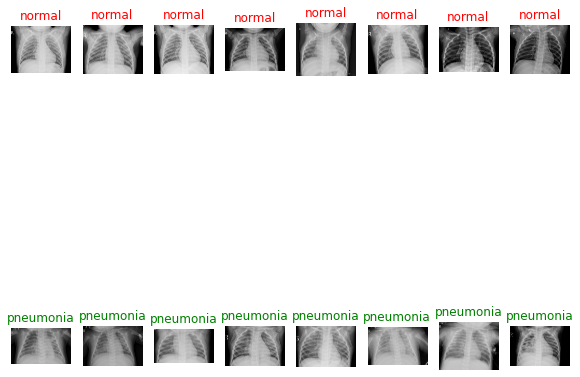

prediction  Normal  Pneumonia
label                        
Normal         121        113
Pneumonia       11        379
The precision score of the model is 0.7703252032520326


In [46]:
svm = SVC(C=100, kernel = 'linear')
svm.fit(x_Train, y_Train)
print('Accuracy of SVM classifier on training set: {:.2f}'
          .format(svm.score(x_Train, y_Train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
          .format(svm.score(x_Test, y_Test)))
print('Accuracy of SVM classifier on validate set: {:.2f}'
          .format(svm.score(x_Validate, y_Validate)))
ShowValidationImagesAndResults(svm)
ShowMetrics(y_Test, svm.predict(x_Test), 'SVM')

<h3>Results</h3>

In [47]:
for model, value in model_precision.items():
    print('Model:: ' + model +" achieved:: " + value + " precision score.")

Model:: Logistic regression achieved:: 0.768762677484787 precision score.
Model:: KNN achieved:: 0.8228438228438228 precision score.
Model:: Discriminant analysis achieved:: 0.766260162601626 precision score.
Model:: Gaussian naive bayes achieved:: 0.780373831775701 precision score.
Model:: SVM achieved:: 0.7703252032520326 precision score.


<h4> After the experiments we conclude that KNN can predict with the higher precision score the pneumonia X - Rays, meaning that with this model we can predict with the higher accuracy the X - Rays which display pneymonia.</h4>